In [2]:
import re
from textblob import TextBlob
import nltk
import json
import pandas 
import csv
import matplotlib.pyplot as plt


In [3]:
from collections import Counter
import io
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


In [10]:
def applyRegexps(text, listRegExp):
    """ Applies successively many regexps to a text"""
    for element in listRegExp:
        left = element['expr']
        right = element['subs']
        r=re.compile(left)
        text=r.sub(right,text)
    return text

def detex(latexText):
    """Transform a latex text into a simple text"""    
    regexps=[]
    text=latexText
    # remove all the contents of the header, ie everything before the first occurence of "\begin{document}"
    text = re.sub(r"(?s).*?(\\begin\{document\})", " ", text, 1)
    
    # remove comments
    regexps.append({r'expr':r'([^\\])%.*', 'subs':r'\1 '})
    text= applyRegexps(text, regexps)
    regexps=[]
    text = text.replace("\n", " ")
    # - replace some LaTeX commands by the contents inside curly rackets
    
    q = re.compile(r'\$\$(.*?)\$\$')
    text = re.sub(q, ' ', text)
    r = re.compile(r'\$(.*?)\$')
    text = re.sub(r, ' ', text)
    text = text.replace("\index", " ")
    
    r = re.compile(r'\\begin{equation}(.*?)\\end{equation}')
    text = re.sub(r, ' ', text)
    
    
    to_reduce = [r'\\emph', r'\\textbf', r'\\textit', r'\\text', r'\\IEEEauthorblockA', 
                 r'\\IEEEauthorblockN', r'\\author', r'\\caption', r'\\thanks']
    for tag in to_reduce:
      regexps.append({'expr':tag+r'\{([^\}\{]*)\}', 'subs':r' \1 '})
    text= applyRegexps(text, regexps)
    regexps=[]

    # - replace some LaTeX commands by the contents inside curly brackets and highlight these contents
    to_highlight = [r'\\part[\*]*', r'\\chapter[\*]*', r'\\section[\*]*', r'\\subsection[\*]*', 
                    r'\\subsubsection[\*]*', r'\\paragraph[\*]*'];
    # highlightment pattern: #--content--#
    for tag in to_highlight:
      regexps.append({'expr':tag+r'\{([^\}\{]*)\}','subs':r'\n\1 \n'})
    # highlightment pattern: [content]
    to_highlight = [r'\\title',r'\\author',r'\\thanks',r'\\cite', r'\\ref'];
    for tag in to_highlight:
      regexps.append({'expr':tag+r'\{([^\}\{]*)\}','subs':r'\1 '})
    text= applyRegexps(text, regexps)
    regexps=[]
    

    # remove LaTeX tags
    # - remove completely some LaTeX commands that take arguments
    to_remove = [r'\\vspace', r'\\medskipamount', r'\\hspace', r'\\tableofcontents', r'\\noindent',
                 r'\\maketitle',r'\\footnote', r'\\centering', r'\\IEEEpeerreviewmaketitle', r'\\Large',
                 r'\\includegraphics', r'\\IEEEauthorrefmark', r'\\label', r'\\begin', r'\\maketitle',
                 r'\\end', r'\\big', r'\\right', r'\\left', r'\\documentclass', 
                 r'\\usepackage', r'\\bibliographystyle', r'\\bibliography',  
                 r'\\cline', r'\\multicolumn', r'\\printindex', r'\\makeindex', r'\\small', r'\\title',
                 r'\\author', r'\\thanks', r'\\cite', r'\\ref', r'\\today', r'\\date', r'\\inde',
                 r'\\bdf', r'\\edf', r'\\tt', r'\\ece', r'\\bce', r'\\la', r'\\ete', r'\\od', r'\\par',
                 r'\\ebla', r'\\dd', r'\\d', r'\\ls', r'\\ubf', r'\\ble', r'\\od\\', r'\\ri', r'\\ls_', r'\\ga',
                 r'\\ti', r'\\vom', r'\\textwidth', r'\\itl', r'\\bf', r'\\vy', r'\\een', r'\\ri ', r'\\rit',
                 r'\\snos', r'\\plo', r'\\bte', r'\\rod', r'\\ele', r'\\bpf', r'\\epf', r'\\bbla', r'\\en', r'\\vpi',
                 r'\\ben', r'\\nenu', r'\\renu', r'\\bcor', r'\\text', r'\\it', r'\\fenu', r'\\atc', r'\\bpn', 
                 r'\\trn', r'\\bpro', r'\\epro', r'\\ep', r'\\ima', r'\\ecor', r'\\pagebreak', r'\\qed', r'\\t',
                 r'\\qe', r'\\bco', r'\\evo', r'\\rm', r'\\ata', r'\\em', r'\\index' ]
    
    # replace tag with options and argument by a single space
    for tag in to_remove:
      regexps.append({'expr':tag+r'(\[[^\]]*\])*(\{[^\}\{]*\})*', 'subs':r' '})
    text= applyRegexps(text, regexps)
    regexps=[]

    
    # - replace some LaTeX commands by the contents inside curly rackets
    # replace some symbols by their ascii equivalent
    # - common symbols
    regexps.append({'expr':r'\\eg(\{\})* *','subs':r'e.g., '})
    regexps.append({'expr':r'\\ldots','subs':r' '})
    regexps.append({'expr':r'\\Rightarrow','subs':r' '})
    regexps.append({'expr':r'\\rightarrow','subs':r' '})
    regexps.append({'expr':r'\\le','subs':r' '})
    regexps.append({'expr':r'\\ge','subs':r' '})
    regexps.append({'expr':r'\\_','subs':r' '})
    regexps.append({'expr':r'\\\\','subs':r'\n'})
    regexps.append({'expr':r'~','subs':r' '})
    regexps.append({'expr':r'\\&','subs':r' '})
    regexps.append({'expr':r'\\%','subs':r' '})
    regexps.append({'expr':r'([^\\])&','subs':r' \1\t'})
    regexps.append({'expr':r'\\item','subs':r' \t- '})
    #regexps.append({'left':r'\\\hline[ \t]*\\hline','right':r'============================================='})
    #regexps.append({'left':r'[ \t]*\\hline','right':r'_____________________________________________'})
    # - special letters
    regexps.append({'expr':r'\\\'{?\{e\}}?','subs':r'é'})
    regexps.append({'expr':r'\\`{?\{a\}}?','subs':r'à'})
    regexps.append({'expr':r'\\\'{?\{o\}}?','subs':r'ó'})
    regexps.append({'expr':r'\\\'{?\{a\}}?','subs':r'á'})
    # keep untouched the contents of the equations
    regexps.append({'expr':r'\$(.)\$', 'subs':r''})
    regexps.append({'expr':r'\$([^\$]*)\$', 'subs':r''})
    # remove the equation symbols ($)
    regexps.append({'expr':r'([^\\])\$', 'subs':r''})
    # correct spacing problems
    regexps.append({'expr':r' +,','subs':r' '})
    regexps.append({'expr':r' +','subs':r' '})
    regexps.append({'expr':r' +\)','subs':r' '})
    regexps.append({'expr':r'\( +','subs':r' '})
    regexps.append({'expr':r' +\.','subs':r' '})    
    # remove lonely curly brackets    
    regexps.append({'expr':r'^([^\{]*)\}', 'subs':r' \1 '})
    regexps.append({'expr':r'([^\\])\{([^\}]*)\}','subs':r' \1\2 '})
    regexps.append({'expr':r'\\\{','subs':r' '})
    regexps.append({'expr':r'\\\}','subs':r' '})
    # strip white space characters at end of line
    regexps.append({'expr':r'[ \t]*\n','subs':r'\n'})
    # remove consecutive blank lines
    regexps.append({'expr':r'([ \t]*\n){3,}','subs':r'\n'})
    # apply all those regexps
    text= applyRegexps(text, regexps)
    regexps=[]    
    # return the modified text
    text = re.sub( '[":$#&!(){}\/.,^*`~=+_@;?]', ' ', text )
    text = text.replace("'"," ").replace("["," ").replace("]"," ").replace("\\"," ")
    return text

def generatePlainText( fname, new_fname ):
    f = open(fname)
    lines = f.readlines()
    f.close()

    original = r""
    for line in lines:
        original += line

    finalText=detex(original)
    #print(finalText)
    f = open(new_fname,"w")  
    f.write(finalText) 
    f.close()
    
generatePlainText("Tex_Files/1.txt", "PlainText/1.txt")
generatePlainText("Tex_Files/2.txt", "PlainText/2.txt")
generatePlainText("Tex_Files/3.txt", "PlainText/3.txt")
generatePlainText("Tex_Files/4.txt", "PlainText/4.txt")
generatePlainText("Tex_Files/5.txt", "PlainText/5.txt")
generatePlainText("Tex_Files/6.txt", "PlainText/6.txt")
generatePlainText("Tex_Files/7.txt", "PlainText/7.txt")
generatePlainText("Tex_Files/8.txt", "PlainText/8.txt")
generatePlainText("Tex_Files/9.txt", "PlainText/9.txt")
generatePlainText("Tex_Files/10.txt", "PlainText/10.txt")
generatePlainText("Tex_Files/11.txt", "PlainText/11.txt")

In [12]:
set(stopwords.words('english'))
stop_words=stopwords.words('english')
new_stopwords=['in','may','said','a','about','above','after','again','against','all','am','an','and','any','are','arent','as','at','be','because','been','before','being','below','between','both','but','by','cant','cannot','could','couldnt','did','didnt','do','does','doesnt','doing','dont','down','during','each','few','for','from','further','had','hadnt','has','hasnt','have','havent','having','he','hed','hell','hes','her','here','heres','hers','herself','him','himself','his','how','hows','i','id','ill','im','ive','if','in','into','is','isnt','it','its','its','itself','lets','me','more','most','mustnt','my','myself','no','nor','not','of','off','on','once','only','or','other','ought','our','ours	ourselves','out','over','own','same','shant','she','shed','shell','shes','should','shouldnt','so','some','such','than','that','thats','the','their','theirs','them','themselves','then','there','theres','these','they','theyd','theyll','theyre','theyve','this','those','through','to','too','under','until','up','very','was','wasnt','we','wed','well','were','weve','were','werent','what','whats','when','whens','where','wheres','which','while','who','whos','whom','why','whys','with','wont','would','wouldnt','you','youd','youll','youre','youve','your','yours','yourself','yourselves'] 
#enter the extra words to be filtered as stop words
for sw in new_stopwords:
    stop_words.append(sw)

In [16]:
file1 = open("/Users/pradeepkumarnama/Desktop/CSE519-2017-Project-master/PlainText/1.txt")
line = file1.read()
words =line.lower().split()
#acceptable_characters =string.digits
for r in words:
    r=re.sub('[^a-zA-Z0-9-_*.]', '', r)
    if not r in stop_words:
        #r=re.sub('[^a-zA-Z0-9-_*]', '', r)
        #filter(lambda c: c in acceptable_characters, r)
        appendFile = open('/Users/pradeepkumarnama/Desktop/CSE519-2017-Project-master/PlainText/1.txt','a')
        #print(" "+r)
        appendFile.write(" "+r)
        appendFile.close

In [4]:
def top_10_rank(finalText, n):
    list = []
    text = nltk.word_tokenize(finalText)
    list = nltk.pos_tag(text)
    list1 = []
    for a in list:
        if a[1] == 'NN'or a[1] == 'NNP' or a[1] == 'NNS' or a[1] == 'JJ':
            list1.append(a[0])
    word_freq = {}
    for word in list1:
        if word in word_freq:
            word_freq[word]+=1
        else:
            word_freq[word] = 1
    dict = {}
    rank = Counter(word_freq)
    rank.most_common()
    for k, v in rank.most_common(n):
        print('%s: %i' % (k, v))
        dict[k] = v
    with open('/Users/pradeepkumarnama/Desktop/CSE519-2017-Project-master/Top_10_words.txt', 'w') as file:
        file.write(json.dumps(dict))  


   
        

In [5]:
num = int(input("Enter number of keywords: "))
top_10_rank(finalText,num)

Enter number of keywords: 10
generic: 102
set: 85
Lemma: 49
sets: 39
such: 38
and\: 38
\: 29
Let: 24
pair: 24
if\: 23


In [6]:
def find_keyword(test_string,n):
    list = []
    text = nltk.word_tokenize(finalText)
    list = nltk.pos_tag(text)
    list1 = []
    for a in list:
        if a[1] == 'NN'or a[1] == 'NNP' or a[1] == 'NNS' or a[1] == 'JJ':
            list1.append(a[0])
    word_freq = {}
    for word in list1:
        if word in word_freq:
            word_freq[word]+=1
        else:
            word_freq[word] = 1
    word_prob_dict = {}
    size_corpus = len(list1)
    for word in word_freq:
        word_prob_dict[word] = float(word_freq[word])/size_corpus

    prob_list = []
    for word, prob in word_prob_dict.items():
         prob_list.append(prob)
    non_exist_prob = min(prob_list)/2

    words = test_string.split()
    test_word_freq = {}
    for word in words:
        if word in test_word_freq:
            test_word_freq[word]+=1
        else:
            test_word_freq[word] = 1

    test_words_ba = {}
    for word, freq in test_word_freq.items():
        if word in word_prob_dict:
            test_words_ba[word] = freq/word_prob_dict[word]
        else:
            test_words_ba[word] = freq/non_exist_prob

    test_word_ba_list = []
    for word, ba in test_words_ba.items():
         test_word_ba_list.append((word, ba))

    def sort_func(a, b):
        if a[1] > b[1]:
           return -1
        elif a[1] < b[1]:
            return 1
            return 0

    return test_word_ba_list[:n]

In [7]:
find_keyword(finalText,10)

[('OD', 1989.0),
 ('elements', 2273.142857142857),
 ('of', 477360.00000000006),
 ('countable', 1988.9999999999998),
 ('sets', 1989.0),
 ('in', 377910.00000000006),
 ('the', 712062.0000000001),
 ('Solovay', 1989.0000000000002),
 ('model', 2099.5),
 ('Vladimir', 1989.0000000000002)]

In [19]:
def extract_key_words():
    lines = []
    updated_list = []
    file1 = open("/Users/pradeepkumarnama/Desktop/CSE519-2017-Project-master/Tex_Files/1.txt","r")
    for line in file1:
        if line.startswith('\index'):
            lines.append(line.strip())
    for element in lines:
        element = str(element)
        element = element.replace("%", " ")
        element = element.replace("\index{", " ")
        element = element.replace("}", " ")
        if re.match("^[a-zA-Z0-9 !-]*$", element):
            updated_list.append(element)
    for x in updated_list:
        print(x +"," + "1")


        

  
    
    
    
   

In [20]:
extract_key_words()

 Solovay model ,1
 double-name ,1
 set!dense ,1
 set!open ,1
 name!full  ,1
 double-name!full  ,1
 name!regular  ,1
 double-name!regular  ,1
 regular hull  ,1
 name!equivalent  ,1
 double-name!equivalent  ,1
 extends  ,1


['rohan', '6']
rohan 6
['raghav', '7']
raghav 7
['ayes', '10']
ayes 10
['harsha', '87']
harsha 87
['maninder', '45']
maninder 45
['ayush', '2']
ayush 2
['neelaabh', '34']
neelaabh 34
['taken', '89']
taken 89
['skeina', '23']
skeina 23
['ferdman', '23']
ferdman 23
['dude', '94']
dude 94
['joy', '12']
joy 12
['koler', '56']
koler 56
Enter number of trials: 3
Enter number of indices: 15
Number of matches: 7
Percentage matches: 50.0
[53.84615384615385]
[1]


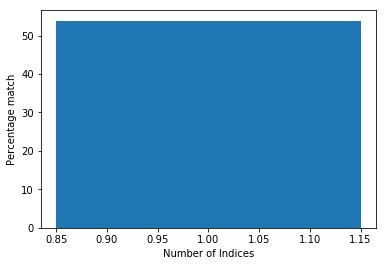

Enter number of indices: 10
Number of matches: 5
Percentage matches: 35.714285714285715
[53.84615384615385, 38.46153846153846]
[1, 2]


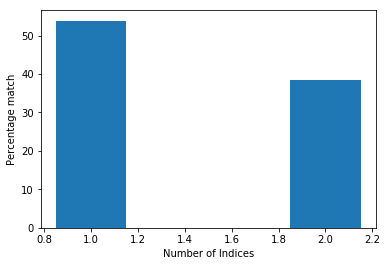

Enter number of indices: 25
Number of matches: 7
Percentage matches: 50.0
[53.84615384615385, 38.46153846153846, 53.84615384615385]
[1, 2, 3]


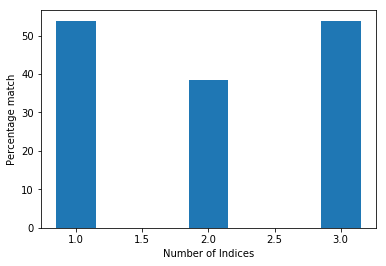

In [21]:
with open('/Users/pradeepkumarnama/Desktop/cse519/CSE519-2017-111447596-master/code/table.txt') as fin:
     d = {}
     for line in fin:
            rows=line.split(',')
            rows[-1] = rows[-1].strip()
            print(rows)
            d[rows[0]] = rows[1]
            print(rows[0],rows[1])
count=0    
num_lines = sum(1 for line in open('/Users/pradeepkumarnama/Desktop/cse519/CSE519-2017-111447596-master/code/tabletest.txt'))
num_lines_OF=sum(1 for line in open('/Users/pradeepkumarnama/Desktop/cse519/CSE519-2017-111447596-master/code/table.txt'))
trials=int(input("Enter number of trials: "))
mylist=[]
mylist1=[]
for i in range(0,trials):
    mylist1.append(i+1)
    num = int(input("Enter number of indices: "))
    with open('/Users/pradeepkumarnama/Desktop/cse519/CSE519-2017-111447596-master/code/tabletest.txt') as fin1:
        for j in range(0,min(num_lines,num)):
            line=fin1.readline()
            rows=line.split(',')
            rows[-1] = rows[-1].strip()
            if rows[0] in d :
                count=count+1
    print('Number of matches:' , count)
    print('Percentage matches:', count*100/num_lines)
    mylist.append(count*100/num_lines_OF)
    count=0
    print(mylist)
    print(mylist1)
    plt.xlabel('Number of Indices')
    plt.ylabel('Percentage match')
    plt.bar(mylist1,mylist,width=0.3)
    plt.show() 
#plt.show()    

            
